In [1]:
#keras

import tensorflow.keras
from keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from tensorflow.keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Using TensorFlow backend.


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
dir_list = os.listdir("/Users/shaha/Downloads/ravdess-emotional-speech-audio/audio_speech_actors_01-24")
RAV="/Users/shaha/Downloads/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
#neutral means calm in my world !!!
RAV_df = RAV_df.replace({1:'calm', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
#RAV_df = RAV_df.replace({1:'positive', 2:'positive', 3:'positive', 4:'negative', 5:'negative', 6:'negative', 7:'negative', 8:'positive'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
#RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
#RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

female_calm        144
male_calm          144
male_fear           96
female_happy        96
female_fear         96
male_surprise       96
female_sad          96
male_disgust        96
female_angry        96
female_surprise     96
male_sad            96
male_happy          96
male_angry          96
female_disgust      96
Name: labels, dtype: int64

In [4]:
length=len(RAV_df)
print(length)
#RAV_df['label']

1440


In [6]:
RAV_df['label']=0

In [7]:
length=len(RAV_df)

for i in range (length):
    if(RAV_df.iloc[i,2]=='female_calm' or RAV_df.iloc[i,2]=='female_happy' or RAV_df.iloc[i,2]=='female_surprise'):
        RAV_df['label'].iloc[i]='female_positive'
    elif(RAV_df.iloc[i,2]=='female_sad' or RAV_df.iloc[i,2]=='female_angry' or RAV_df.iloc[i,2]=='female_fear' or RAV_df.iloc[i,2]=='female_disgust'):
        RAV_df['label'].iloc[i]='female_negative'
    elif(RAV_df.iloc[i,2]=='male_sad' or RAV_df.iloc[i,2]=='male_angry' or RAV_df.iloc[i,2]=='male_fear' or RAV_df.iloc[i,2]=='male_disgust'):
        RAV_df['label'].iloc[i]='male_negative'
    else:
        RAV_df['label'].iloc[i]='male_positive'

In [8]:
RAV_df

,gender,emotion,labels,path,label
0,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
1,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
2,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
3,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
4,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
...,...,...,...,...,...
1435,female,surprise,female_surprise,/Users/shaha/Downloads/ravdess-emotional-speec...,female_positive
1436,female,surprise,female_surprise,/Users/shaha/Downloads/ravdess-emotional-speec...,female_positive
1437,female,surprise,female_surprise,/Users/shaha/Downloads/ravdess-emotional-speec...,female_positive
1438,female,surprise,female_surprise,/Users/shaha/Downloads/ravdess-emotional-speec...,female_positive


In [9]:
'''
1. Data Augmentation method   
'''
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

'''
2. Extracting the MFCC feature as an image (Matrix format).  
'''
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X


'''
3. Confusion matrix plot 
'''        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
'''
# 4. Create the 2D CNN model 
'''
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 9
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer='rmsprop', loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


'''
# 5. Other functions 
'''
class get_results:
    '''
    We're going to create a class (blueprint template) for generating the results based on the various model approaches. 
    So instead of repeating the functions each time, we assign the results into on object with its associated variables 
    depending on each combination:
        1) MFCC with no augmentation  
        2) MFCC with augmentation 
        3) Logmelspec with no augmentation 
        4) Logmelspec with augmentation
    '''
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        pres1=precision_score(actual, preds, average='weighted')
        print("Precision score = ", pres1)
        rec1=recall_score(actual, preds, average='weighted')
        print("Recall score = ", rec1)
        f1s=f1_score(actual, preds, average='weighted')
        print("F1 score = ", f1s)
        print_confusion_matrix(c, class_names = classes)
        
    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_angry':'female'
               , 'female_disgust':'female'
               , 'female_fear':'female'
               , 'female_happy':'female'
               , 'female_sad':'female'
               , 'female_surprise':'female'
               , 'female_neutral':'female'
               , 'male_angry':'male'
               , 'male_fear':'male'
               , 'male_happy':'male'
               , 'male_sad':'male'
               , 'male_surprise':'male'
               , 'male_neutral':'male'
               , 'male_disgust':'male'
              })

        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

In [10]:
ref = pd.DataFrame(RAV_df)
ref.head()

,gender,emotion,labels,path,label
0,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
1,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
2,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
3,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
4,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive


In [11]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc, aug = 0, mfcc = 1)


100%|██████████| 1440/1440 [02:43<00:00,  8.80it/s]


In [12]:
ref[['label', 'labels']]

,label,labels
0,male_positive,male_calm
1,male_positive,male_calm
2,male_positive,male_calm
3,male_positive,male_calm
4,male_positive,male_calm
...,...,...
1435,female_positive,female_surprise
1436,female_positive,female_surprise
1437,female_positive,female_surprise
1438,female_positive,female_surprise


In [13]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# Split between train and test
X_train, X_test, y2_train, y2_test = train_test_split(mfcc
 , ref[['label', 'labels']]
 , test_size=0.1
 , shuffle=True
 , random_state=42
 )

In [14]:
y2_train

,label,labels
32,male_negative,male_angry
614,male_positive,male_happy
394,male_negative,male_angry
724,male_positive,male_calm
898,male_positive,male_surprise
...,...,...
1095,male_positive,male_happy
1130,male_negative,male_disgust
1294,female_negative,female_angry
860,male_negative,male_sad


In [15]:
y_train=pd.DataFrame(y2_train.iloc[:,0])
y_test=pd.DataFrame(y2_test.iloc[:,0])

In [16]:


# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


In [271]:


# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=30)

Train on 1296 samples, validate on 144 samples
Epoch 1/30
1296/1296 - 41s - loss: 1.2794 - acc: 0.4259 - val_loss: 1.0660 - val_acc: 0.5000
Epoch 2/30
1296/1296 - 43s - loss: 0.9136 - acc: 0.5309 - val_loss: 1.5398 - val_acc: 0.2500
Epoch 3/30
1296/1296 - 42s - loss: 0.7935 - acc: 0.5988 - val_loss: 1.9791 - val_acc: 0.2986
Epoch 4/30
1296/1296 - 43s - loss: 0.7134 - acc: 0.6489 - val_loss: 0.6954 - val_acc: 0.6597
Epoch 5/30
1296/1296 - 44s - loss: 0.6405 - acc: 0.6983 - val_loss: 0.5859 - val_acc: 0.7847
Epoch 6/30
1296/1296 - 44s - loss: 0.6115 - acc: 0.7153 - val_loss: 0.6559 - val_acc: 0.7500
Epoch 7/30
1296/1296 - 44s - loss: 0.5360 - acc: 0.7778 - val_loss: 0.6624 - val_acc: 0.6875
Epoch 8/30
1296/1296 - 45s - loss: 0.4705 - acc: 0.8079 - val_loss: 0.5346 - val_acc: 0.7778
Epoch 9/30
1296/1296 - 45s - loss: 0.4491 - acc: 0.8187 - val_loss: 1.3134 - val_acc: 0.5833
Epoch 10/30
1296/1296 - 45s - loss: 0.3637 - acc: 0.8534 - val_loss: 0.5294 - val_acc: 0.7778
Epoch 11/30
1296/1296 

In [272]:
 
# serialize model to JSON
model_json = model.to_json()
with open("model_1st_level_classification2_90acc.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2_90acc.h5")
print("Saved model to disk")
 

Saved model to disk


In [17]:
 
# load json and create model
json_file = open('model_1st_level_classification2_90acc.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2_90acc.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 95.14%


In [21]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
preds=preds.argmax(axis=1)
#preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))

actual = y_test.argmax(axis=1)
#actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))


accu1=accuracy_score(actual, preds)
print("Accurcy = ", accu1)
pres1=precision_score(actual, preds, average='weighted')
print("Precision score = ", pres1)
rec1=recall_score(actual, preds, average='weighted')
print("Recall score = ", rec1)
f1s=f1_score(actual, preds, average='weighted')
print("F1 score = ", f1s)
        

Accurcy =  0.9027777777777778
Precision score =  0.916414355781928
Recall score =  0.9027777777777778
F1 score =  0.9029985222185312


In [193]:
preds

array(['male_negative', 'male_negative', 'female_positive',
       'female_positive', 'male_negative', 'male_positive',
       'female_positive', 'female_negative', 'female_positive',
       'male_negative', 'female_negative', 'female_positive',
       'male_negative', 'female_positive', 'male_negative',
       'female_negative', 'female_negative', 'male_negative',
       'female_positive', 'female_negative', 'female_positive',
       'female_positive', 'female_positive', 'male_negative',
       'female_negative', 'male_negative', 'male_positive',
       'male_positive', 'male_negative', 'male_negative', 'male_negative',
       'male_negative', 'male_positive', 'male_negative', 'male_positive',
       'male_positive', 'male_negative', 'male_negative',
       'female_negative', 'male_negative', 'female_positive',
       'male_positive', 'female_positive', 'male_negative',
       'male_positive', 'male_positive', 'female_positive',
       'male_positive', 'female_negative', 'female_negat

In [194]:
ref

,gender,emotion,labels,path,label
0,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
1,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
2,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
3,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
4,male,calm,male_calm,/Users/shaha/Downloads/ravdess-emotional-speec...,male_positive
...,...,...,...,...,...
1435,female,surprise,female_surprise,/Users/shaha/Downloads/ravdess-emotional-speec...,female_positive
1436,female,surprise,female_surprise,/Users/shaha/Downloads/ravdess-emotional-speec...,female_positive
1437,female,surprise,female_surprise,/Users/shaha/Downloads/ravdess-emotional-speec...,female_positive
1438,female,surprise,female_surprise,/Users/shaha/Downloads/ravdess-emotional-speec...,female_positive


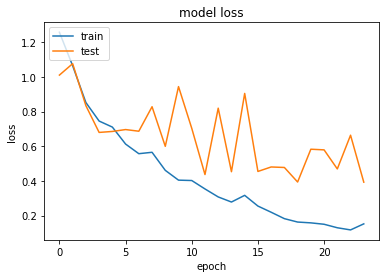

accuracy: 84.72%
360/1 - 9s


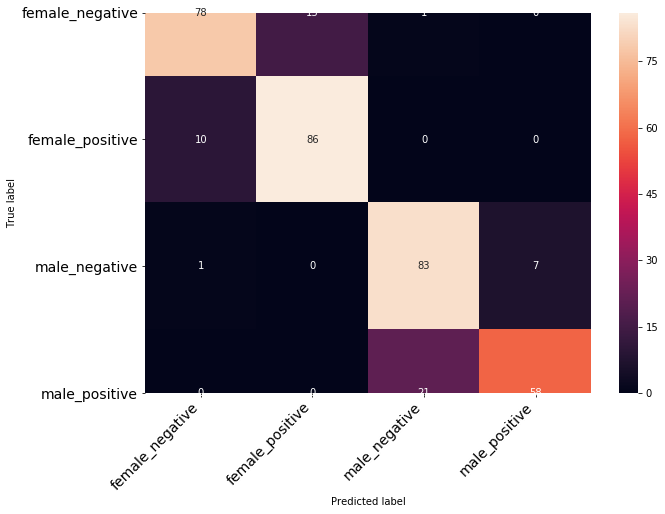

In [180]:
results = get_results(model_history,loaded_model,X_test,y_test, ref.label.unique())
results.create_plot(model_history)
results.create_results(loaded_model)
results.confusion_results(X_test, y_test, ref.label.unique(), loaded_model)

In [ ]:
#really good at gender classification 

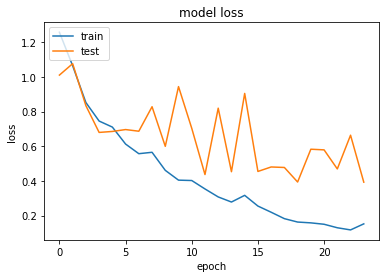

accuracy: 84.72%
1080/1 - 25s


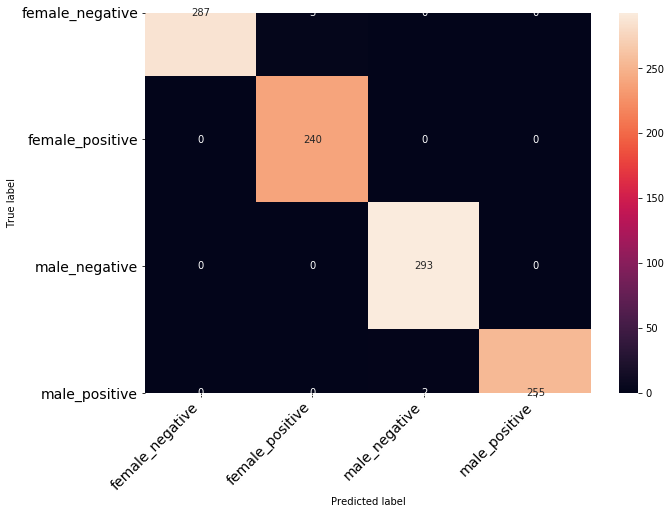

In [33]:
results = get_results(model_history,model,X_train,y_train, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_train, y_train, ref.labels.unique(), model)

In [25]:
preds_train = loaded_model.predict(X_train, 
                         batch_size=16, 
                         verbose=2)
preds_train=preds_train.argmax(axis=1)
#preds_train = preds_train.astype(int).flatten()
preds_train = (lb.inverse_transform((preds_train)))

actual_train = y_train.argmax(axis=1)
#actual_train = actual_train.astype(int).flatten()
actual_train = (lb.inverse_transform((actual_train)))

1296/1 - 30s


In [26]:
y2_train

,label,labels
32,male_negative,male_angry
614,male_positive,male_happy
394,male_negative,male_angry
724,male_positive,male_calm
898,male_positive,male_surprise
...,...,...
1095,male_positive,male_happy
1130,male_negative,male_disgust
1294,female_negative,female_angry
860,male_negative,male_sad


In [27]:
new_X=np.vstack((X_train,X_test))


#new_y=np.vstack((preds_train,preds))

new_y=np.append(preds_train,preds, axis=0)
new_true_y=np.append(y2_train.iloc[:,1],y2_test.iloc[:,1], axis=0)

In [28]:
new_y

array(['male_negative', 'male_positive', 'male_negative', ...,
       'female_negative', 'female_negative', 'male_positive'],
      dtype=object)

In [29]:
new_true_y

array(['male_angry', 'male_happy', 'male_angry', ..., 'female_angry',
       'female_happy', 'male_happy'], dtype=object)

In [30]:
preds_train.shape

(1296,)

In [31]:
preds.shape

(144,)

In [32]:
len1=new_y.shape[0]

In [33]:
new_X[0].shape

(30, 216, 1)

In [34]:
new_y[0]

'male_negative'

In [36]:
pos_x=[]
pos_y=[]
neg_x=[]
neg_y=[]
pos_true_y=[]
neg_true_y=[]

for i in range(len1):
    if(new_y[i]=='male_positive' or new_y[i]=='female_positive'):
        pos_x=np.append(pos_x,new_X[i])
        pos_y=np.append(pos_y,new_y[i])
        pos_true_y=np.append(pos_true_y,new_true_y[i])
    else:
        neg_x=np.append(neg_x,new_X[i])
        neg_y=np.append(neg_y,new_y[i])
        neg_true_y=np.append(neg_true_y,new_true_y[i])
        

In [37]:
neg_true_y

array(['male_angry', 'male_angry', 'female_fear', 'male_fear',
       'female_sad', 'male_fear', 'female_fear', 'male_sad',
       'female_fear', 'male_sad', 'male_angry', 'female_angry',
       'female_sad', 'male_angry', 'female_sad', 'male_fear',
       'female_angry', 'female_disgust', 'male_fear', 'male_angry',
       'female_sad', 'female_fear', 'female_sad', 'female_angry',
       'female_angry', 'male_sad', 'male_disgust', 'female_fear',
       'female_sad', 'male_sad', 'female_fear', 'female_disgust',
       'female_fear', 'male_sad', 'female_sad', 'female_angry',
       'male_disgust', 'female_sad', 'male_disgust', 'female_fear',
       'male_fear', 'female_angry', 'female_angry', 'female_sad',
       'female_disgust', 'female_fear', 'male_sad', 'female_disgust',
       'female_sad', 'male_sad', 'female_sad', 'female_sad',
       'male_disgust', 'female_angry', 'female_angry', 'male_disgust',
       'female_angry', 'male_disgust', 'female_sad', 'male_angry',
       'male_sad'

In [38]:
#replace any "positive" emotion with ('other')
leng=len(neg_y)
neg_true_y_modified=np.empty_like(neg_true_y)
for i in range(leng):
    
    
    if(neg_true_y[i] == 'male_happy' or neg_true_y[i] == 'female_happy' or neg_true_y[i]== 'female_calm' or neg_true_y[i] == 'male_calm' or neg_true_y[i] == 'female_surprise' or neg_true_y[i] == 'male_surprise'):
        neg_true_y_modified[i]='other'
    else:
        neg_true_y_modified[i]=neg_true_y[i]

In [39]:
#other for male and female ???
np.unique(neg_true_y_modified)


array(['female_angry', 'female_disgust', 'female_fear', 'female_sad',
       'male_angry', 'male_disgust', 'male_fear', 'male_sad', 'other'],
      dtype='<U32')

In [40]:
neg_true_y

array(['male_angry', 'male_angry', 'female_fear', 'male_fear',
       'female_sad', 'male_fear', 'female_fear', 'male_sad',
       'female_fear', 'male_sad', 'male_angry', 'female_angry',
       'female_sad', 'male_angry', 'female_sad', 'male_fear',
       'female_angry', 'female_disgust', 'male_fear', 'male_angry',
       'female_sad', 'female_fear', 'female_sad', 'female_angry',
       'female_angry', 'male_sad', 'male_disgust', 'female_fear',
       'female_sad', 'male_sad', 'female_fear', 'female_disgust',
       'female_fear', 'male_sad', 'female_sad', 'female_angry',
       'male_disgust', 'female_sad', 'male_disgust', 'female_fear',
       'male_fear', 'female_angry', 'female_angry', 'female_sad',
       'female_disgust', 'female_fear', 'male_sad', 'female_disgust',
       'female_sad', 'male_sad', 'female_sad', 'female_sad',
       'male_disgust', 'female_angry', 'female_angry', 'male_disgust',
       'female_angry', 'male_disgust', 'female_sad', 'male_angry',
       'male_sad'

In [ ]:
# female_calm        144
# male_calm          144
# male_angry          96
# male_surprise       96
# female_happy        96
# female_disgust      96
# female_fear         96
# female_sad          96
# male_fear           96
# female_surprise     96
# female_angry        96
# male_sad            96
# male_disgust        96
# male_happy          96

In [41]:
#replace any "positive" emotion with ('other')
leng=len(pos_y)
pos_true_y_modified=np.empty_like(pos_true_y)
for i in range(leng):
    
    
    if(pos_true_y[i] == 'male_happy' or pos_true_y[i] == 'female_happy' or pos_true_y[i]== 'female_calm' or pos_true_y[i] == 'male_calm' or pos_true_y[i] == 'female_surprise' or pos_true_y[i] == 'male_surprise'):
        pos_true_y_modified[i]=pos_true_y[i]
    else:
        pos_true_y_modified[i]='other'

In [42]:
pos_true_y

array(['male_happy', 'male_calm', 'male_surprise', 'female_calm',
       'female_happy', 'male_calm', 'male_surprise', 'female_happy',
       'female_calm', 'female_calm', 'female_surprise', 'female_calm',
       'female_calm', 'male_surprise', 'male_happy', 'female_happy',
       'female_happy', 'female_calm', 'male_calm', 'female_surprise',
       'female_calm', 'male_surprise', 'female_surprise', 'female_calm',
       'male_surprise', 'male_calm', 'male_happy', 'male_surprise',
       'female_happy', 'female_surprise', 'female_calm',
       'female_surprise', 'male_surprise', 'male_surprise', 'female_calm',
       'male_calm', 'female_surprise', 'female_surprise', 'male_calm',
       'male_calm', 'female_surprise', 'male_calm', 'male_happy',
       'female_happy', 'male_calm', 'male_calm', 'male_calm', 'male_calm',
       'female_surprise', 'female_calm', 'male_calm', 'female_calm',
       'female_calm', 'female_calm', 'male_calm', 'female_surprise',
       'female_surprise', 'male_

In [43]:
np.unique(pos_true_y_modified)

array(['female_calm', 'female_happy', 'female_surprise', 'male_calm',
       'male_happy', 'male_surprise', 'other'], dtype='<U32')

In [44]:
neg_true_y.shape #male_happy 

(766,)

In [45]:
neg_y.shape

(766,)

In [46]:
neg_x=neg_x.reshape((neg_y.shape[0],new_X.shape[1],new_X.shape[2],new_X.shape[3]))

In [47]:
neg_x.shape

(766, 30, 216, 1)

In [48]:
pos_x=pos_x.reshape((pos_y.shape[0],new_X.shape[1],new_X.shape[2],new_X.shape[3]))

In [49]:
pos_x.shape

(674, 30, 216, 1)

In [50]:
new_X.shape[1]

30

In [51]:
neg_y.shape[0]

766

In [52]:
new_X2=np.vstack((X_train,X_test))


#new_y=np.vstack((preds_train,preds))

new_y_all=np.append(y_train,y_test, axis=0)

In [ ]:
print(neg_y_emo.size)
print(neg_y.size)

In [246]:
(neg_x.shape)

(776, 30, 216, 1)

In [ ]:
#so basically neg_y won't be used, right?


In [ ]:
#neg_X is already extracted 

In [53]:
print(pos_true_y_modified.shape)
print(pos_x.shape)

(674,)
(674, 30, 216, 1)


In [54]:
neg_true_y_modified.shape

(766,)

In [55]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# Split between train and test 
X_train2, X_test2, y_train2, y_test2 = train_test_split(neg_x
                                                    , neg_true_y_modified
                                                    , test_size=0.1
                                                    , shuffle=True
                                                    , random_state=111
                                                   )

# one hot encode the target 
lb = LabelEncoder()
y_train2 = np_utils.to_categorical(lb.fit_transform(y_train2))
y_test2 = np_utils.to_categorical(lb.fit_transform(y_test2))

# Normalization as per the standard NN process
mean = np.mean(X_train2, axis=0)
std = np.std(X_train2, axis=0)

X_train2 = (X_train2 - mean)/std
X_test2 = (X_test2 - mean)/std


In [56]:
y_test2

array([[0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1.

In [61]:
# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), 
                    batch_size=16, verbose = 2, epochs=40)

Train on 689 samples, validate on 77 samples
Epoch 1/40
689/689 - 48s - loss: 2.0758 - acc: 0.2511 - val_loss: 1.7609 - val_acc: 0.4286
Epoch 2/40
689/689 - 41s - loss: 1.8092 - acc: 0.3149 - val_loss: 2.3174 - val_acc: 0.1558
Epoch 3/40
689/689 - 41s - loss: 1.6054 - acc: 0.4165 - val_loss: 2.2019 - val_acc: 0.1818
Epoch 4/40
689/689 - 37s - loss: 1.4483 - acc: 0.4557


KeyboardInterrupt: 

In [255]:


 
# serialize model to JSON
model_json = model.to_json()
with open("model_2nd_level_classification_negative2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model21_2.h5")
print("Saved model to disk")

Saved model to disk


In [64]:
# load json and create model
json_file = open('model_2nd_level_classification_negative.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model21.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test2, y_test2, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 99.28%


In [65]:
preds = loaded_model.predict(X_test2, 
                         batch_size=16, 
                         verbose=2)
preds=preds.argmax(axis=1)
#preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))

actual = y_test2.argmax(axis=1)
#actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))


accu1=accuracy_score(actual, preds)
print("Accurcy = ", accu1)
pres1=precision_score(actual, preds, average='weighted')
print("Precision score = ", pres1)
rec1=recall_score(actual, preds, average='weighted')
print("Recall score = ", rec1)
f1s=f1_score(actual, preds, average='weighted')
print("F1 score = ", f1s)
       

77/1 - 2s
Accurcy =  0.961038961038961
Precision score =  0.9504225932797361
Recall score =  0.961038961038961
F1 score =  0.9546684252566606


In [68]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# Split between train and test 
X_train3, X_test3, y_train3, y_test3 = train_test_split(pos_x
                                                    , pos_true_y_modified
                                                    , test_size=0.1
                                                    , shuffle=True
                                                    , random_state=0
                                                   )


# one hot encode the target 
lb = LabelEncoder()
y_train3 = np_utils.to_categorical(lb.fit_transform(y_train3))
y_test3 = np_utils.to_categorical(lb.fit_transform(y_test3))

# Normalization as per the standard NN process
mean = np.mean(X_train3, axis=0)
std = np.std(X_train3, axis=0)

X_train3 = (X_train3 - mean)/std
X_test3 = (X_test3 - mean)/std

In [320]:
# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train3, y_train3, validation_data=(X_test3, y_test3), 
                    batch_size=16, verbose = 2, epochs=30)

Train on 606 samples, validate on 68 samples
Epoch 1/30
606/606 - 38s - loss: 1.7877 - acc: 0.3168 - val_loss: 1.5209 - val_acc: 0.3235
Epoch 2/30
606/606 - 32s - loss: 1.3489 - acc: 0.4983 - val_loss: 1.2049 - val_acc: 0.5588
Epoch 3/30
606/606 - 31s - loss: 1.1550 - acc: 0.6040 - val_loss: 1.6244 - val_acc: 0.4706
Epoch 4/30
606/606 - 36s - loss: 1.0200 - acc: 0.6073 - val_loss: 1.7684 - val_acc: 0.3971
Epoch 5/30
606/606 - 34s - loss: 0.8881 - acc: 0.6683 - val_loss: 1.8456 - val_acc: 0.3971
Epoch 6/30
606/606 - 35s - loss: 0.8563 - acc: 0.7046 - val_loss: 1.9050 - val_acc: 0.3529
Epoch 7/30
606/606 - 36s - loss: 0.7683 - acc: 0.7244 - val_loss: 1.1714 - val_acc: 0.5735
Epoch 8/30
606/606 - 36s - loss: 0.6720 - acc: 0.7673 - val_loss: 1.0932 - val_acc: 0.5735
Epoch 9/30
606/606 - 37s - loss: 0.6024 - acc: 0.8069 - val_loss: 1.0359 - val_acc: 0.6324
Epoch 10/30
606/606 - 31s - loss: 0.6204 - acc: 0.7921 - val_loss: 1.5563 - val_acc: 0.5000
Epoch 11/30
606/606 - 26s - loss: 0.5263 - a

In [319]:
np.unique(pos_true_y_modified)

array(['female_calm', 'female_happy', 'female_surprise', 'male_calm',
       'male_happy', 'male_surprise', 'other'], dtype='<U32')

In [321]:
 
# serialize model to JSON
model_json = model.to_json()
with open("model_2nd_level_classification_positive.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model22.h5")
print("Saved model to disk")

Saved model to disk


In [69]:
 
# load json and create model
json_file = open('model_2nd_level_classification_positive.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model22.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test3, y_test3, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Loaded model from disk
accuracy: 97.48%


In [70]:
preds = loaded_model.predict(X_test3, 
                         batch_size=16, 
                         verbose=2)
preds=preds.argmax(axis=1)
#preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))

actual = y_test3.argmax(axis=1)
#actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))


accu1=accuracy_score(actual, preds)
print("Accurcy = ", accu1)
pres1=precision_score(actual, preds, average='weighted')
print("Precision score = ", pres1)
rec1=recall_score(actual, preds, average='weighted')
print("Recall score = ", rec1)
f1s=f1_score(actual, preds, average='weighted')
print("F1 score = ", f1s)
       

68/1 - 2s
Accurcy =  0.8970588235294118
Precision score =  0.8893288084464555
Recall score =  0.8970588235294118
F1 score =  0.8879488502553519
